# Comparing _autodifferentiation_ & _finite differences_ in Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal

In [134]:
##Local settings
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import galsim
import tensorflow as tf

## Generate Data

In [4]:
psf_noise = 1.0e-6
img_noise = 1.0e-5
scale = 0.263
stamp_size = 50
psf_fwhm = 0.9
gal_hlr = 0.5
seed = 31415
rng = np.random.RandomState(seed)

psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm)

obj0 = galsim.Exponential(half_light_radius=gal_hlr)

obj = galsim.Convolve(psf, obj0)

psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

psf_image += rng.normal(scale=psf_noise, size=psf_image.shape)
gal_image += rng.normal(scale=img_noise, size=gal_image.shape)

In [5]:
gal_image = tf.expand_dims(tf.convert_to_tensor(gal_image),axis=0)
psf_image = tf.expand_dims(tf.convert_to_tensor(psf_image),axis=0)

In [6]:
gal_image[0][0]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 1.1630130e-05,  6.8052200e-06,  9.1157253e-06, -2.4851408e-07,
        4.0964555e-06,  9.4787438e-06, -1.5269472e-06,  7.8035913e-07,
       -1.2199341e-05, -3.4145764e-06, -7.4622080e-06,  3.7155646e-06,
        2.5075160e-06,  1.7229109e-05, -1.1516634e-06, -5.3989097e-06,
       -6.0365119e-06,  1.5964542e-05, -8.7171429e-06, -9.7735292e-06,
       -6.3924585e-06,  8.9128753e-06,  7.8812918e-06, -3.9042502e-06,
        1.8063207e-05, -8.7552216e-06,  1.7703842e-05, -1.1262126e-05,
       -1.0439932e-05, -1.1365715e-05,  1.8753351e-05,  4.3547561e-06,
       -9.0845242e-06,  4.4443177e-06, -1.0687772e-05, -1.6136768e-05,
        6.5090358e-06,  2.5279347e-05,  1.5949156e-05,  1.4818290e-05,
       -2.0474322e-06,  1.1870385e-06,  2.0136674e-06,  8.5647607e-06,
        3.9879893e-07, -1.3777647e-05,  1.3921129e-05,  1.4071766e-05,
       -1.8093604e-05, -2.1650667e-06], dtype=float32)>

Text(0.5, 1.0, 'psf model')

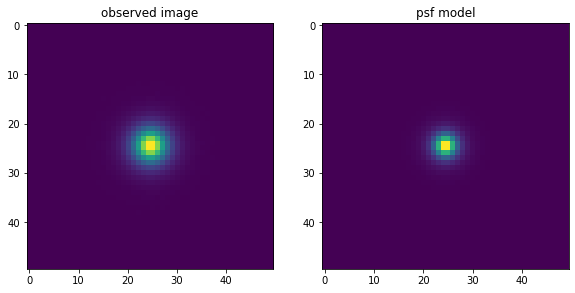

In [7]:
figure(figsize=(15,5))
subplot(131)
imshow(gal_image[0]); title('observed image')
subplot(132)
imshow(psf_image[0]); title('psf model')


## Generate a 20% larger PSF for reconvolution.

In [8]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

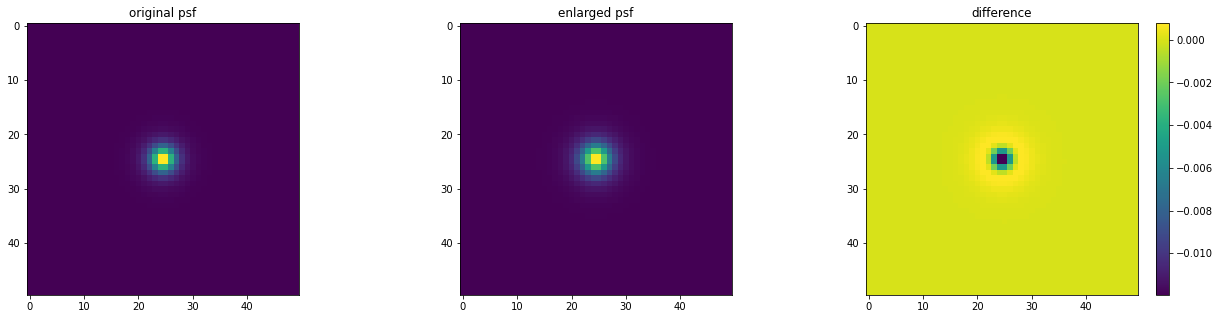

In [9]:
figure(figsize=(22,5))
subplot(131)
imshow(psf_image[0]); title('original psf')
subplot(132)
imshow(reconv_psf_image[0]); title('enlarged psf')
subplot(133)
imshow(reconv_psf_image[0] - psf_image[0]); title('difference');colorbar()

## Test GalFlow Deconv/Reconv

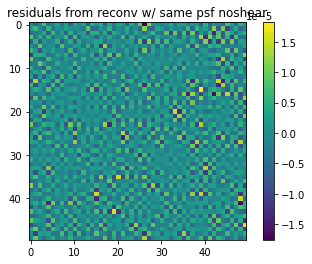

In [10]:
imshow(autometacal.generate_mcal_image(gal_image,psf_image,psf_image,[[0.0,0.0]])[0]-gal_image[0]);title('residuals from reconv w/ same psf noshear');colorbar()


## GalFlow vs GalSim

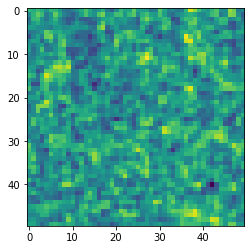

In [11]:
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.expand_dims( tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])

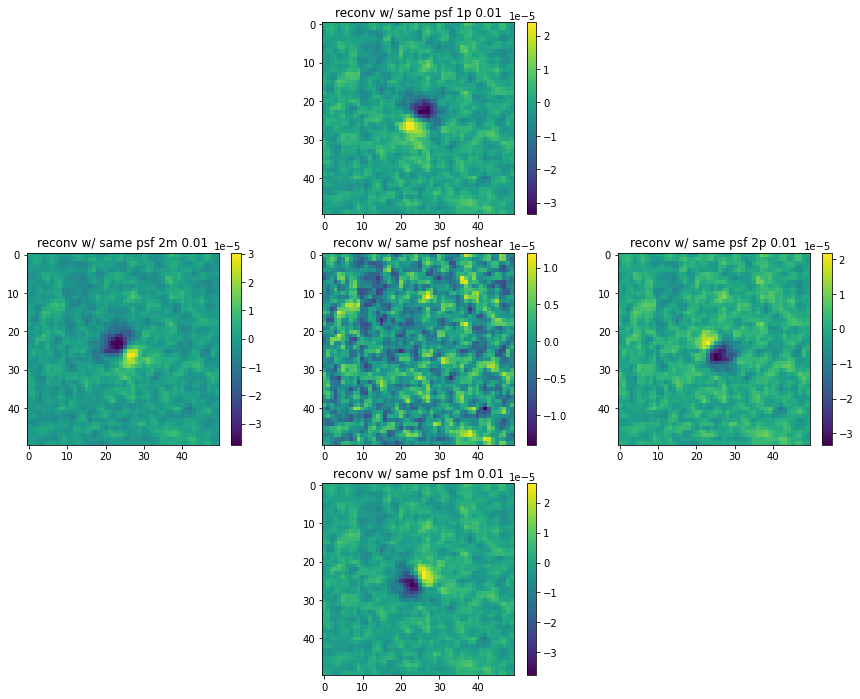

In [12]:
figure(figsize=(15,12))

step = 0.01

subplot(335)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])
title('reconv w/ same psf noshear');colorbar()

subplot(332)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=step,g2=0.0)])
counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1p {step}');colorbar()

subplot(338)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=-step,g2=0.0)])
counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[-step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1m {step}');colorbar()

subplot(336)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=step)])
counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2p {step}');colorbar()

subplot(334)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=-step)])
counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,-step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2m {step}');colorbar()

## Simple Ellipticity Measurements

In [49]:
def get_ellipticity(img):
  img_size = len(img[0])
  nx = img_size
  ny = img_size
  XX=np.zeros((nx,ny))
  XY=np.zeros((nx,ny))
  YY=np.zeros((nx,ny))
  w = np.zeros((nx,ny))
  sigma=img_size/5
  
  for i in range(0,nx):
      x=0.5+i-(nx)/2.0
      for j in range(0,ny):
          y=0.5+j-(ny)/2.0
          XX[i,j]=x*x
          XY[i,j]=x*y
          YY[i,j]=y*y
          w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                                 (2 * sigma ** 2))
  
  img = tf.convert_to_tensor(img, dtype=tf.float32)
  norm = tf.reduce_sum(tf.reduce_sum(w*img, axis=-1), axis=-1)
  Q11 = tf.reduce_sum(tf.reduce_sum(w*img*YY, axis=-1), axis=-1)/norm
  Q12 = tf.reduce_sum(tf.reduce_sum(w*img*XY, axis=-1), axis=-1)/norm
  Q21 = Q12
  Q22 = tf.reduce_sum(tf.reduce_sum(w*img*XX, axis=-1), axis=-1)/norm
  q1 = Q11 - Q22
  q2 = 2*Q12
  T= Q11 + Q22  + 2*tf.sqrt(Q11*Q22 - Q12**2)
  r = tf.stack([q1/T, q2/T], axis=-1)
  return r

In [69]:
g1, g2 = get_ellipticity(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,0.0]])[0])
print(f'0shear  g1={g1: .4f},  g2={g2: .4f}')
print('--------------------------------')
g1, g2 = get_ellipticity(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.05,0.0]])[0])
print(f'1p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticity(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[-.05,0.0]])[0])
print(f'1m .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticity(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,0.05]])[0])
print(f'2p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticity(autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0.0,-.05]])[0])
print(f'2m .05  g1={g1: .4f},  g2={g2: .4f}')

0shear  g1=-0.0001,  g2=-0.0004
--------------------------------
1p .05  g1= 0.0130,  g2=-0.0004
1m .05  g1=-0.0131,  g2=-0.0004
2p .05  g1=-0.0001,  g2= 0.0127
2m .05  g1=-0.0001,  g2=-0.0134


## Autodiff

In [152]:
e, R =autometacal.get_metacal_response(gal_image,psf_image,reconv_psf_image,get_ellipticity)
calibre=tf.linalg.inv(R) @ tf.reshape(e,[2,1])
print(f'g1 = {calibre[0,0,0]: .5f}, g2 = {calibre[0,1,0]: .5f}')

g1 = -0.00030, g2 = -0.00158


In [153]:
print(f'e = {np.sqrt(sum(calibre**2)): .5f}')

e =  0.00161


## Single image comparison between Autodiff and Finite diff

In [154]:
def get_metacal_response_finitediff(gal_image,psf_image,reconv_psf_image,step,method):
  
  img0s = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]]) 
  img1p = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[step,0]]) 
  img1m = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[-step,0]]) 
  img2p = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,step]]) 
  img2m = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,-step]]) 
  
  g0s = get_ellipticity(img0s)
  g1p = get_ellipticity(img1p)
  g1m = get_ellipticity(img1m)
  g2p = get_ellipticity(img2p)
  g2m = get_ellipticity(img2m) 
  
  d11 = (g1p[0,0]-g1m[0,0])/(2*step)
  d12 = (g1p[0,1]-g1m[0,1])/(2*step)
  d21 = (g2p[0,0]-g2m[0,0])/(2*step)
  d22 = (g2p[0,1]-g2m[0,1])/(2*step)
  
  
  R = np.array([[d11,d12],[d21,d22]])
  return g0s, R
  
e_f, R_f =get_metacal_response_finitediff(gal_image=gal_image,
                                          psf_image=psf_image,
                                          reconv_psf_image=reconv_psf_image,
                                          step=0.01,
                                          method=get_ellipticity)
calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
print(f'g1 = {calibre_f[0,0]: .5f}, g2 = {calibre_f[1,0]: .5f}') 

g1 = -0.00030, g2 = -0.00158


In [155]:
e=np.sqrt(sum(calibre**2))

In [159]:
steps = np.logspace(-3,-1,500)
ef_list = []
for step in steps:
  e_f, R_f=get_metacal_response_finitediff(gal_image,psf_image,reconv_psf_image,step,get_ellipticity)
  try:
    calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
    ef_list.append(np.sqrt(sum(calibre_f**2)))
  except:
    ef_list.append(np.nan)
    print('Ops!')

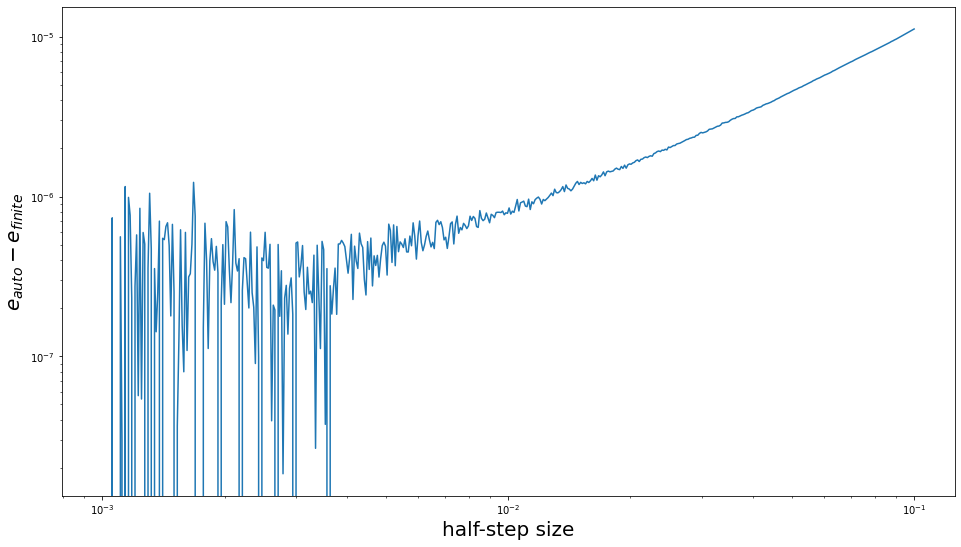

In [160]:
figure(figsize=(16,9))
plot(steps,e-np.array(ef_list) )
xscale('log')
yscale('log')
ylabel('$e_{auto} - e_{finite}$',fontsize=20)
xlabel('half-step size',fontsize=20)
savefig(f'autofinite{time.time()}.jpeg',bbox_inches='tight')